# Text Analysis and Entity Resolution 

## Part 0: Preliminaries

In [1]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

def removeQuotes(s):
    """ Remove quotation marks from an input string
    Args:
        s (str): input string that might have the quote "" characters
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i != '"')

def parseDatafileLine(datafileLine):
    """ Parse a line of the data file using the specified regualr expression pattern
    Args:
        datafileLine (str): input string that is a line from the data file
    Returns:
        str: a string parsed using the given regular expression and without the quote characters
    """
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print('Invalid datafile line: {0}'.format(datafileLine))
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print('Header datafile line: {0}'.format(datafileLine))
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

In [2]:
import os
data_dir = os.path.join('user', 'root', 'lab3')
GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    """ Parse a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: an RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())
def loadData(path):
    """ Load a data file
    Args:
        path (str): input file name of the data file
    Returns:
        RDD: an RDD of parsed valid lines 
    """
    filename = 'hdfs:/' + os.path.join(data_dir, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0])
              .cache())
    for line in failed.take(10):
        print('%s - Invalid datafile line: %s' % (path, line))
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print('{0} - Read {1} lines, successfully parse {2} lines, failed to parse {3} lines'
          .format(path, raw.count(), valid.count(), failed.count()))
    assert failed.count() == 0
    assert raw.count() == (valid.count()+1)
    return valid

googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

Google_small.csv - Read 201 lines, successfully parse 200 lines, failed to parse 0 lines
Google.csv - Read 3227 lines, successfully parse 3226 lines, failed to parse 0 lines
Amazon_small.csv - Read 201 lines, successfully parse 200 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parse 1363 lines, failed to parse 0 lines


In [3]:
for line in googleSmall.take(3):
    print('google: {0}: {1}\n'.format(line[0], line[1]))

for line in amazonSmall.take(3):
    print('amazon: {0}: {1}\n'.format(line[0], line[1]))

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup 

## Part 1: ER as Text Similarity - Bags of Words

### (1a) Tokenize a String

In [4]:
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    return [t for t in re.split(split_regex, string.lower()) if len(t)]

#test cases
print(simpleTokenize(quickbrownfox))
print(simpleTokenize(' '))
print(simpleTokenize('!!!!123A/456_B/789C.123A'))
print(simpleTokenize('fox fox'))

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
[]
['123a', '456_b', '789c', '123a']
['fox', 'fox']


### (1b) Removing Stopwords

In [5]:
stopfile = os.path.join('lab3', STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
print('These are the stopwords: %s' % stopwords)

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    return [t for t in re.split(split_regex, string.lower()) if len(t) and t not in stopwords]

#test cases
print(tokenize(quickbrownfox))
print(tokenize('Why a the?'))
print(tokenize('Being at the_?'))

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

### (1c) Tokenizing the small datasets 

In [6]:
amazonRecToToken = amazonSmall.map(lambda x:(x[0], tokenize(x[1])))
googleRecToToken = googleSmall.map(lambda x:(x[0], tokenize(x[1])))

def countTokens(vendorRDD):
    """ Count and return the number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    recordCount = vendorRDD.map(lambda s:len(s[1]))
    recordSum = recordCount.reduce(lambda a, b:a+b)
    return recordSum

totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken)
print('There are {0} tokens in the combined datasets'.format(totalTokens))

There are 22520 tokens in the combined datasets


### (1d) Amazon record with the most tokens

In [7]:
def findBiggestRecord(vendorRDD):
    """ Find and return the record with the largest number of tokens
    Args:
        vendorRDD (RDD of (recordID, tokens): input Pair Tuple of record ID and tokens)
    Returns:
        list: a list of 1 Pair Tuple of record ID and tokens
    """
    return (vendorRDD.takeOrdered(1, lambda s: -1 * len(s[1])))

biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print('The Amazon record with ID "{0}" has the most tokens ({1})'.format(biggestRecordAmazon[0][0], len(biggestRecordAmazon[0][1])))

The Amazon record with ID "b000o24l3q" has the most tokens (1547)


## Part 2: ER as Text Similarity - Weighted Bag-of-Words using TF-IDF

### TF: Term Frequency
$TF=\frac{T_a}{T_{total}}$
* $T_a$: number of times that token $t$ appears in a document $d$
* $T_{total}$: total number of tokens in a document $d$

### IDF: Inverse-Document-Frequency
$IDF=\frac{N}{n(t)}$
* $N$: total number of documents in a set of documents $U$.
* $n(t)$: the number of documents in $U$ that contain $t$

### (2a) Implement a TF function

In [8]:
def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    counts = {}
    length = len(tokens)
    for t in tokens:
        counts.setdefault(t, 0.0)
        counts[t] += 1
    return {t:counts[t]/length for t in counts}

#test cases
print(tf(tokenize(quickbrownfox)))
print(tf(tokenize('one_ One_ two!')))

{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}
{'two': 0.3333333333333333, 'one_': 0.6666666666666666}


### (2b) Create a corpus

In [9]:
corpusRDD = amazonRecToToken.union(googleRecToToken)

### (2c) Implement a IDF function

In [10]:
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: an RDD of (token, IDF value)
    """
    N = float(corpus.count())
    uniqueTokens = corpus.flatMap(lambda s: set(s[1]))
    tokenCountPairTuple = uniqueTokens.map(lambda s: (s,1))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda x, y: x+y)
    return (tokenSumPairTuple.map(lambda s: (s[0], float(N/s[1]))))

idfsSmall = idfs(amazonRecToToken.union(googleRecToToken))
uniqueTokenCount = idfsSmall.count()

print('There are {0} unique tokens in the small datasets.'.format(uniqueTokenCount))

tokenSmallestIdf = idfsSmall.takeOrdered(1, lambda s: s[1])[0]
print(tokenSmallestIdf[0])
print(tokenSmallestIdf[1])

There are 4772 unique tokens in the small datasets.
software
4.25531914894


### (2d) Tokens with the smallest IDF

In [11]:
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print(smallIDFTokens)

[('software', 4.25531914893617), ('new', 6.896551724137931), ('features', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('create', 8.333333333333334), ('system', 8.333333333333334), ('cd', 8.333333333333334), ('1', 8.51063829787234), ('windows', 8.51063829787234)]


### (2e) IDF Histogram

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


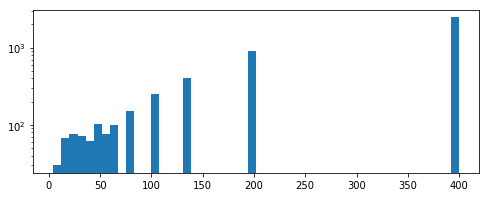

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
fig.show()

In [13]:
from pyspark.sql import Row

idfsToCountRow = idfsSmall.map(lambda (x,y):(x,y))
idfsToCountDF = sqlContext.createDataFrame(idfsToCountRow, ('token', 'value'))
idfsToCountDF.show()

+-------------+-----------------+
|        token|            value|
+-------------+-----------------+
|        aided|            400.0|
|      precise|            100.0|
|       duplex|            400.0|
|        dance|            400.0|
|         four|66.66666666666667|
|     timecode|            400.0|
|       verses|            400.0|
|       battle|            100.0|
|         9999|            400.0|
|        album|            400.0|
|relationships|            200.0|
|     increase|66.66666666666667|
|          xml|            400.0|
|           tv|            200.0|
|     gamecard|            400.0|
|       german|            400.0|
|        topic|            400.0|
|     ambience|            400.0|
|    nightfall|            400.0|
|   multistore|            200.0|
+-------------+-----------------+
only showing top 20 rows



### (2f) Implement a TF-IDF function

In [14]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): inputlist of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tfIdfDict = {t: tfs[t] * idfs[t] for t in tfs}
    return tfIdfDict

recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights)
print('Amazon record "b000hkgj8k" has tokens and weights:\n{0}'.format(rec_b000hkgj8k_weights))

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 33.33333333333333, 'autodesk': 8.333333333333332, 'courseware': 66.66666666666666, 'psg': 33.33333333333333, '2007': 3.5087719298245617, 'customizing': 16.666666666666664, 'interface': 3.0303030303030303}


## Part 3: ER as Text Similarity - Cosine Similarity

Cosine similarity is defined as
\begin{equation}
\text{similarity}=\cos(\theta)=\frac{a\cdot b}{|a||b|}=\frac{\sum a_ib_i}{\sqrt{\sum a_i^2}\sqrt{\sum b_i^2}}
\end{equation}

### (3a) Implement the components of a `cosineSimilarity` function

In [15]:
import math

def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        dotProd: result of the dot product with the tow input dictionaries
    """
    return sum([a[t] * b[t] for t in a if t in b])

def norm(a):
    """ Compute square root of the dot product
    Args:
        a (dictionary): a dictionary of record to value
    Returns:
        norm (float): the square root of the dot product value
    """
    return math.sqrt(dotprod(a, a))

def cossim(a,b):
    """ Compute cosine similarity
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        cossim (float): cosine similarity
    """
    return dotprod(a, b) / (norm(a) * norm(b))

# test cases
testVec1 = {1:2, 2:3, 3:5}
testVec2 = {1:1, 2:0, 3:20}
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print(dp, nm)

(102, 6.164414002968976)


### (3b) Implement a `cosineSimilarity` function 

In [16]:
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim (float): cosine similarity value
    """
    w1 = tfidf(tokenize(string1), idfsDictionary)
    w2 = tfidf(tokenize(string2), idfsDictionary)
    return cossim(w1, w2)

# test case
cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)
print(cossimAdobe)

0.0577243382163


### (3c) Perform Entity Resolution

In [17]:
crossSmall = (googleSmall
              .cartesian(amazonSmall)
              .cache())
def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)

similarities = (crossSmall
                .map(computeSimilarity)
                .cache())

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is {0}'.format(similarityAmazonGoogle))

Requested similarity is 0.000303171940451


### (3d) Perform Entity Resolution with Broadcast Variables

In [18]:
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(computeSimilarityBroadcast)
                         .cache())

def similarBoradcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity
    """
    return (similaritiesBroadcast
            .filter(lambda record: record[0] == googleURL and record[1] == amazonID)
            .collect()[0][2])
similarityAmazonGoolgeBroadcast = similarBoradcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is {0}'.format(similarityAmazonGoolgeBroadcast))

Requested similarity is 0.000303171940451


### (3e) Perform a Gold Standard Evaluation

In [19]:
GOLDFILE_PATTERN = '^(.+),(.+)'

def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold'), 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print('Invalid goldfile line: {0}'.format(goldfile_line))
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: {0}'.format(goldfile_line))
        return (goldfile_line, 0)
    else:
        key = '{0} {1}'.format(removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)
    
goldfile = os.path.join('lab3', GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())
gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print('Invalid goldfile line: {0}'.format(line))

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print('Read {0} lines, successfully parsed {1} lines, failed to parse {2} lines'.format(gsRaw.count(),
                                                                                        goldStandard.count(),
                                                                                        gsFailed.count()))
assert gsFailed.count() == 0
assert gsRaw.count() == (goldStandard.count()+1)

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


In [20]:
sims = similaritiesBroadcast.map(lambda x:('{0} {1}'.format(x[1], x[0]), x[2]))

trueDupsRDD = (sims
               .join(goldStandard)
               .map(lambda x: x[1][0]))
trueDupsCount = trueDupsRDD.count()
avgSimDups = float(trueDupsRDD.reduce(lambda x, y : x + y)) / float(trueDupsCount)

nonDupsRDD = (sims
              .leftOuterJoin(goldStandard)
              .filter(lambda x: x[1][1] is None)
              .map(lambda a: a[1][0]))
avgSimNon = float(nonDupsRDD.reduce(lambda a, b : a + b)) / float(sims.count() - trueDupsCount)
print('There are {0} true duplicates.'.format(trueDupsCount))
print('The average similarity of true duplicates is {0}'.format(avgSimDups))
print('And for non duplicates it is {0}'.format(avgSimNon))

There are 146 true duplicates.
The average similarity of true duplicates is 0.264332573435
And for non duplicates it is 0.00123476304656


## Part 4: Scalable ER

### Inverted Indices
We can use invered index to avoid making quadratically many token comparisons.

### (4a) Tokenize the full dataset

In [21]:
amazonFullRecToToken = amazon.map(lambda s: (s[0], tokenize(s[1])))
googleFullRecToToken = google.map(lambda s: (s[0], tokenize(s[1])))
print('Amazon full dataset is {0} products, Google full dataset is {1} products'.format(amazonFullRecToToken.count(), googleFullRecToToken.count()))

Amazon full dataset is 1363 products, Google full dataset is 3226 products


### (4b) Compute IDFs and TF-IDFs for the full datasets

In [22]:
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print('There are {0} unique tokens in the full dataset'.format(idfsFullCount))

# Recompute IDFs for full dataset
idfsFullWeights = idfsFull.collectAsMap()
idfsFullBroadcast = sc.broadcast(idfsFullWeights)

# Pre-compute TF-IDF weights. Build mappings fro record ID weight vector
amazonWeightsRDD = amazonFullRecToToken.map(lambda x: (x[0], tfidf(x[1], idfsFullBroadcast.value)))
googleWeightsRDD = googleFullRecToToken.map(lambda x: (x[0], tfidf(x[1], idfsFullBroadcast.value)))
print('There are {0} Amazon weights and {1} Google weights.'.format(amazonWeightsRDD.count(), googleWeightsRDD.count()))

There are 17078 unique tokens in the full dataset
There are 1363 Amazon weights and 3226 Google weights.


### (4c) Compute Norms for the weights from the full datasets 

In [23]:
amazonNorms = amazonWeightsRDD.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
amazonNormsBroadcast = sc.broadcast(amazonNorms)
googleNorms = googleWeightsRDD.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
googleNormsBroadcast = sc.broadcast(googleNorms)
print('There are {0} Amazon norms and {1} Google norms'.format(len(amazonNorms), len(googleNorms)))

There are 1363 Amazon norms and 3226 Google norms


### (4d) Create inverted indices from the full datasets

In [24]:
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    rId = record[0]
    vec = record[1]
    pairs = [(tok, rId) for tok in vec]
    return (pairs)

amazonInvPairsRDD = (amazonWeightsRDD
                     .flatMap(invert)
                     .cache())
googleInvPairsRDD = (googleWeightsRDD
                     .flatMap(invert)
                     .cache())
print('There are {0} Amazon inverted pairs and {1} Google inverted pairs'.format(amazonInvPairsRDD.count(), googleInvPairsRDD.count()))

There are 111387 Amazon inverted pairs and 77678 Google inverted pairs


### (4e) Identify common tokens from the full dataset

In [25]:
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

commonTokens = (amazonInvPairsRDD
                .join(googleInvPairsRDD)
                .map(swap)
                .groupByKey()
                .map(lambda rec: (rec[0], list(rec[1])))
                .cache())
print('Found {0} common tokens'.format(commonTokens.count()))


Found 2441100 common tokens


### (4f) Identify common tokens from the full dataset

In [26]:
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum([amazonWeightsBroadcast.value[amazonRec][t] * googleWeightsBroadcast.value[googleRec][t] for t in tokens])
    value = s / googleNormsBroadcast.value[googleRec] / amazonNormsBroadcast.value[amazonRec]
    key = (amazonRec, googleRec)
    return (key, value)

similaritiesFullRDD = (commonTokens.map(fastCosineSimilarity).cache())
print(similaritiesFullRDD.count())

2441100


## Part 5: Analysis

\begin{equation}
Fmeasure = 2\times\frac{precision\times recall}{precision+recall}
\end{equation}

### (5a) Counting True Positives, False Positives, and False Negatives

In [27]:
# Create an RDD of ((AmazonID, GoogleURL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ('{0} {1}'.format(x[0][0],x[0][1]), x[1]))
assert simsFullRDD.count() == 2441100

# Create an RDD of just the similarity score
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert simsFullValuesRDD.count() == 2441100

# Look up all similarity scores for true duplicates
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print('There are {0} true duplicates.'.format(trueDupSimsRDD.count()))
assert trueDupSimsRDD.count() == 1300

There are 1300 true duplicates.


In [28]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)
    
    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1
    
# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
            bits.append(value)
        else:
            bits.append(0)
    return bits

# Pre-bin counts of false positive for different thresholds
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)
    
simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]


### (5b) Precision, Recall, and F-measures
\begin{eqnarray}
Precision &=& \frac{TP}{TP+FP} \\
Recall &=& \frac{TP}{TP+FN} \\
Fmeasure &=& 2\times\frac{Recall\times Precision}{Recall+Precision}
\end{eqnarray}

In [29]:
def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    
    return 2 * r * p / (r + p)

### (5c) Line Plots

(0.0005325468026709271, 0.0010645266950540452)


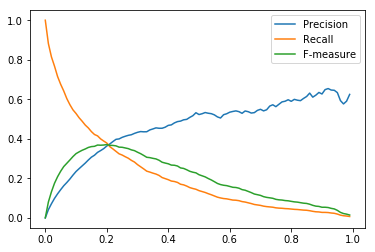

In [30]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print(precisions[0], fmeasures[0])
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)

fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
fig.show()

In [31]:
graph = [(t, precision(t), recall(t), fmeasure(t)) for t in thresholds]
graphRDD = sc.parallelize(graph)
graphRow = graphRDD.map(lambda (t, x, y, z): Row(threshold=t, precision=x, recall=y, fmeasure=z))
graphDF = sqlContext.createDataFrame(graphRow)
graphDF.show()

+--------------------+--------------------+-------------------+---------+
|            fmeasure|           precision|             recall|threshold|
+--------------------+--------------------+-------------------+---------+
|0.001064526695054...|5.325468026709271E-4|                1.0|      0.0|
| 0.08061002178649238| 0.04223433242506812| 0.8823076923076923|     0.01|
|  0.1325489705238125|  0.0721438790108318| 0.8146153846153846|     0.02|
| 0.17584353801427186| 0.09929360262660432| 0.7676923076923077|     0.03|
|  0.2089183421318657| 0.12232013678810996| 0.7153846153846154|     0.04|
| 0.23648103309120258| 0.14329964134333226| 0.6761538461538461|     0.05|
|  0.2601651347561926|  0.1631177964446181| 0.6423076923076924|     0.06|
|  0.2767495152476644| 0.17951063343242626| 0.6038461538461538|     0.07|
|  0.2934226073257188| 0.19719428268925357|  0.573076923076923|     0.08|
|  0.3106838540528731| 0.21696673787000306|  0.546923076923077|     0.09|
|  0.3255152807391613| 0.2351934269085